In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import milp, LinearConstraint, Bounds

In [3]:
def build_adj(data):
    '''
    Given a data matrix that contains the edges that connect vertices, this function builds the adjacency matrix that connects edges
    '''
    vertices = np.max(data)
    adj = np.zeros((vertices+1, vertices+1))
    for i in range(0,len(data)):
        adj[int(data[i,0]),int(data[i,1])] = 1
        adj[int(data[i,1]),int(data[i,0])] = 1
    return adj  

def maxclique(adj):
    '''
    Given adjacency matrix, returns the vertices of maximum clique
    '''
    l = len(adj)
    adjcomp = 1 - adj - np.eye(l)
    [v1,v2] = np.where(adjcomp==1)
    A = np.zeros((len(v1),l))
    b = np.ones(len(v1))
    for i in range(0,len(v1)):
        A[i,v1[i]] = 1
        A[i,v2[i]] = 1
    
    f = -np.ones(l)
    integrality = np.ones(l)
    lb = np.zeros(l)
    ub = np.ones(l)
    variable_bounds = Bounds(lb, ub)
    constraints = LinearConstraint(A, -np.inf, b)
    res_milp = milp(f, integrality=integrality, bounds=variable_bounds, constraints=constraints) 
    res_milp.x = [int(x_i) for x_i in res_milp.x]
    new_vertices = np.where(abs(res_milp.x + f) < 0.001)[0].tolist()   
    return new_vertices

In [7]:
df = pd.read_csv('cleaned_mlb_2022_full.csv')

# Focus on players with at least 100 PAs
df = df[df['PA'] >= 100].reset_index(drop=True)

# Build similarity edges: let's say players are connected if their EV and LA are within a threshold
feature_cols = ['Barrel%', 'EV', 'LA']
X = df[feature_cols].values
threshold = 2.5

edges = []
for i in range(len(X)):
    for j in range(i + 1, len(X)):
        if np.linalg.norm(X[i] - X[j]) < threshold:
            edges.append([i, j])

edges = np.array(edges)
adj = build_adj(edges)
clique_indices = maxclique(adj)
clique_df = df.iloc[clique_indices]

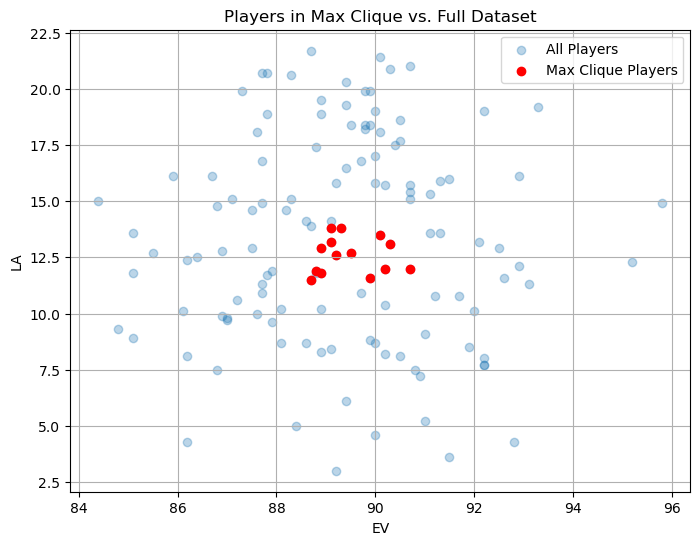

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(df['EV'], df['LA'], alpha=0.3, label='All Players')
plt.scatter(clique_df['EV'], clique_df['LA'], color='red', label='Max Clique Players')
plt.xlabel('EV')
plt.ylabel('LA')
plt.title('Players in Max Clique vs. Full Dataset')
plt.legend()
plt.grid(True)
plt.show()

This scatter plot visualizes all players (in blue) alongside those identified in the maximum clique (in red), plotted by Exit Velocity (EV) and Launch Angle (LA). The clique members form a tight, centralized cluster around 90 mph EV and 12.5 degree LA. These values suggest ideal contact conditions associated with productive batted ball events. This plot reflects a key principle of the max clique algorithm: all red points are mutually similar (connected), meaning each player in the clique lies within the predefined distance threshold to every other player. Here, the clique provides a data-driven grouping of players with nearly indistinguishable batted-ball profiles, which could inform strategies for lineup optimization, platoon considerations, or trade value comparisons among statistically redundant players.

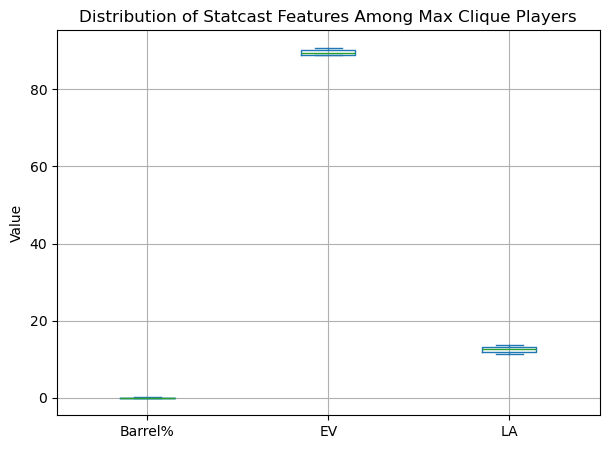

In [13]:
clique_df[feature_cols].plot(kind='box', figsize=(7,5))
plt.title("Distribution of Statcast Features Among Max Clique Players")
plt.ylabel("Value")
plt.grid(True)
plt.show()

This boxplot displays the distribution of three Statcast features, Barrel%, Exit Velocity, and Launch Angle, among players in the maximum clique. Unlike the full dataset, where values might vary widely, the clique shows extremely tight interquartile ranges, particularly for EV and LA, with minimal outliers. Barrel% also clusters tightly, though the low magnitude values amplify even small variation. This visualization reinforces the structural guarantee of the clique: every member satisfies pairwise proximity constraints across all selected features. As a result, we observe a naturally compressed statistical distribution. This uniformity is especially useful when teams seek interchangeable players or when modeling consistency in performance under specific batted ball expectations.

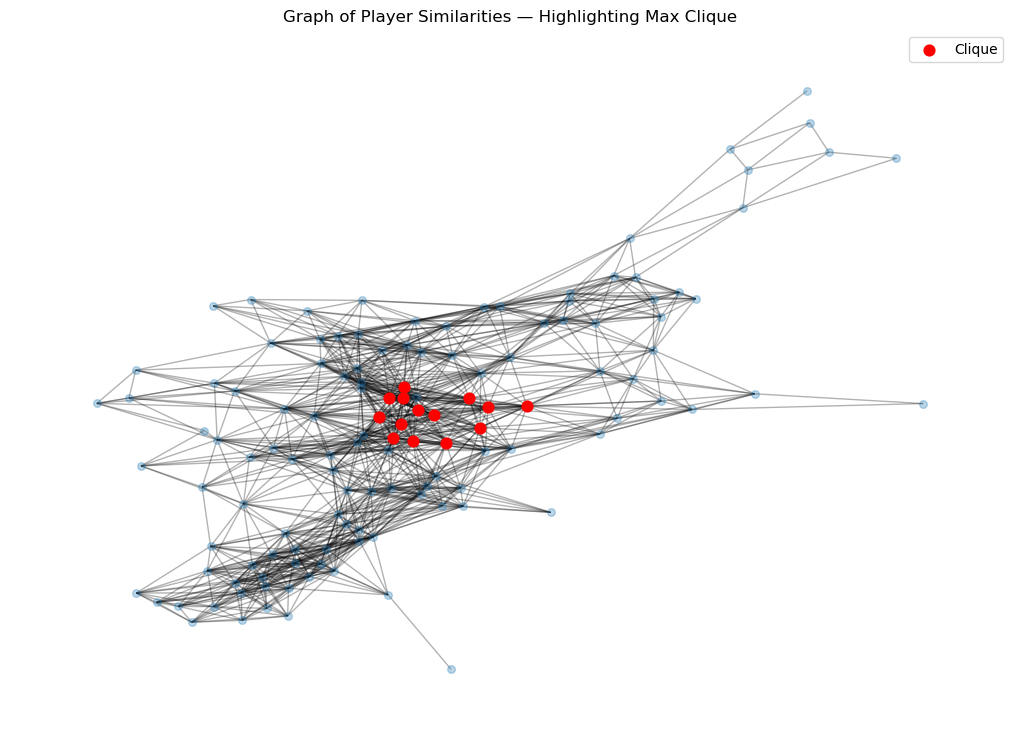

In [15]:
G = nx.Graph()
G.add_edges_from([tuple(e) for e in edges])
clique_nodes = clique_indices

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=30, alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes, node_color='red', node_size=60, label='Clique')
plt.title("Graph of Player Similarities — Highlighting Max Clique")
plt.legend()
plt.show()

This graph visualizes the network structure underlying the dataset, where each node is a player, and edges represent Statcast-based similarity. The red nodes contrast sharply with the broader network, which contains players with sparse and partial similarity connections. By solving a mixed-integer linear program over the graph’s complement (which encodes conflicts or dissimilarities), we isolate the largest group of players that are all mutually similar under the given distance metric. This subgraph can be viewed as the statistically densest cluster, a valuable concept in identifying redundancies or constructing depth charts from a similarity-based perspective.

Max clique is fundamentally different from clustering or nearest-neighbor methods, which focus on proximity to a centroid or limited local similarity. Instead, the clique framework guarantees total mutual agreement, making it well-suited for applications like interchangeable player identification, roster redundancy analysis, or group scouting for minor league development. Visualizations of the EV-LA space, boxplots of feature distributions, and the graph structure itself reveal how the clique isolates a statistically tight, high-consistency core of players.